In [1]:
# Copyright 2018 Anar Amirli
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Target Analyizing

In this project, we aim to find ball location during the game. We've got two approaches for that:<br>
1. Divide pitch into segments of various sizes and find ball location using classification
2. Find ball location itself using regression

Alyzing teams' struction we saw that that teams tend to keep their vertical structure. Therefore, we've divided pitch into the **9** segments. In our data set we're not given ball location for each data frame, we're only given player informations; such as it's speed, coordinates, which team and which player has the ball.
If any player has the ball for a moment, we accept its location as ball location and use this location to label our target value (for finding ball location segment index) from **1 to 9**.<br>
<br>**Null index(0)** represents all the other index categories, apart from the ones we are interested in, that occur when the game stops.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import scipy as sc
import pandas as pd
import operator
import math
import json

pd.options.display.max_columns = None

pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)


# reading all the matches 
with open('../data/general/matches_2017_2018_v1.json') as matches_json:
    matches = json.load(matches_json)
    
pitch_index_data = np.zeros(shape=(1), dtype=np.int)    
match_count = 0
for match_data in matches:
    match_id = int(match_data['id'])
    try:
        
        features_df = pd.read_csv('../data/match_{}/features_set.csv'.format(match_id))
        pitch_index_data = np.concatenate((pitch_index_data, features_df['pitch_index']), axis=0)
        match_count +=1
    except FileNotFoundError:
        pass

### Histogram of target detecion (ball location segments)

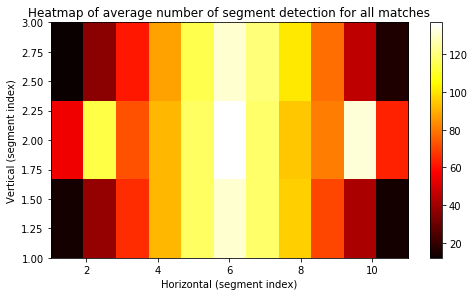

In [5]:
ball_detected = []
pitch_index_data[550961]=0

index_dict = {'x':{}, 'y':{}}

index = 1
for i in range(1,12):
    for j in range(1,4):
        index_dict['x'][index] = i
        index_dict['y'][index] = j
        index +=1
        
pitch_segment_data = np.zeros(shape=(4,12), dtype=np.int)
pitch_segment_data_count = np.zeros(shape=(34), dtype=np.int)  
out_off_play=0

for i in pitch_index_data:
    if i != 0:
        pitch_segment_data[ index_dict['y'][i] ] [ index_dict['x'][i] ] += 1
    else:
        out_off_play+=1

average_event_frame =  len(pitch_index_data)//match_count # average second that a single match last
pitch_segment_data = pitch_segment_data//match_count 

pitch_segment_count = np.zeros(shape=(4,12), dtype=np.int)  
out_off_play //=match_count # number of null ball location



pitch_segment_data_count[0]=out_off_play

# calculating avrg segmet detection number for whole matches 
for i in pitch_index_data:
    if i != 0:
        y = index_dict['y'][i]
        x = index_dict['x'][i]
        if pitch_segment_count[y][x]<=pitch_segment_data[y][x]:
            pitch_segment_data_count[int(i)] +=1
            pitch_segment_count[y][x] += 1
            ball_detected.append([x,y])

        
ball_detected = np.array(ball_detected)

plt.figure(figsize=(8, 4.33))  # 14x21 number of segments that we divided pitch into
plt.hist2d((ball_detected[:,0]), (ball_detected[:,1]), cmap='hot', bins=(11,3))

plt.title('Heatmap of average number of segment detection for all matches')
plt.xlabel('Horizontal (segment index)')
plt.ylabel('Vertical (segment index)')
plt.colorbar();
plt.show()

Histogram of ball segments isn't concentrated on the certain area of the pitch, however, it is more tended to center and more common in the goal regions as expected. This result seems to be promising in case of detecting ball position segmenet. Although data seems to be okay, abnormally, index 1 detected many times, which is significantly higher than the other most occurred pitch segments. We should consider this in the next steps. We solved this abnormal occurrence, it was noise in raw data.

In [15]:
print("5 least occured segment and its value:\n")

print('\nSegment\t#Occurence')
print('-------\t----------')
for i in range(5):
    print('{}\t{}'.format(ball_location_index[i][0], ball_location_index[i][1]))


average_count = 0
for i in range(len(ball_location_index)-2):
    average_count += ball_location_index[i][1]

average_count /= (len(ball_location_index)-2)

print("\nAverage number of occurance of segments: " + str(int(average_count)))

5 least occured segment and its value:


Segment	#Occurence
-------	----------
3	12
1	14
31	14
33	16
6	36

Average number of occurance of segments: 79


### Inbalanced target data

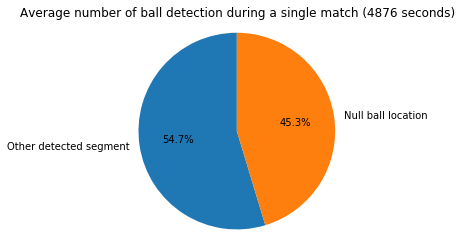

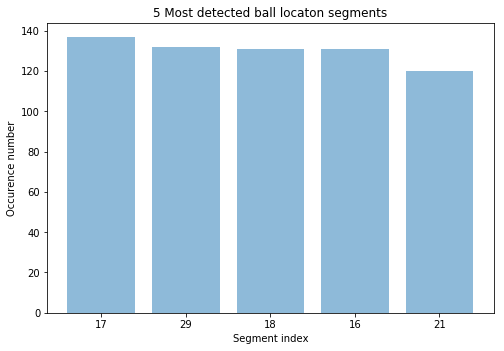

In [13]:
ball_location_index = {}
for i in range(0,34):
    ball_location_index[i]=pitch_segment_data_count[i]


ball_location_index = sorted(ball_location_index.items(), key=operator.itemgetter(1))    
    

labels = 'Other detected segment', 'Null ball location' 
sizes = [average_event_frame-out_off_play,out_off_play]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)

ax1.axis('equal')
plt.title('Average number of ball detection during a single match ('+ str(average_event_frame) + ' seconds)')
plt.show()


location_dection=[]
index=[]


for i in range(1,6):
    location_dection.append(ball_location_index[33-i][1])
    index.append(str(ball_location_index[33-i][0]))
    
    y_pos = np.arange(len(index))
    
width = 8
plt.figure(figsize=(width, width/1.5))
plt.bar(y_pos, location_dection, align='center', alpha=0.5)
plt.xticks(y_pos, index)
plt.ylabel('Occurence number')
plt.xlabel('Segment index')
plt.title('5 Most detected ball locaton segments')
 
plt.show()

As it seems in the pie chart above, ball location (location index in this case) data is far more imbalanced, where the number of null ball location events almost equals to the total number of ball detected frames.Thus, while building our train and test set we should reduce the number of frames of the null ball in our data set. But cosidering the fact that they are most common, we should keep their numbers close to the number of other most occurred ball location indexes.

Some segmment assigment has been assigned very few times, while buildling our training set we should consider this case again.
#### What we can do?
1. We ca ignore some least occured segment while building our training set
2. We can reduce target segment size